In [1]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
import seaborn as sns
from datetime import datetime

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\choi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
pd_tweets = pd.read_csv('VitalikButerin_tweets.csv')
pd_tweets = pd_tweets.drop(['UserName', "Handle", "Likes", "Retweets", "Text"], axis=1)
pd_tweets = pd_tweets.astype({'Comments' : 'string'})
# pd_tweets['Timestamp'] = pd_tweets['Timestamp'].apply(lambda x: datetime.strptime(x[:10] + ' ' + x[11:19], '%Y-%m-%d %H:%M:%S'))
pd_tweets['Timestamp'] = pd_tweets['Timestamp'].apply(lambda x: datetime.strptime(x[:10] + ' ' + '09:00:00', '%Y-%m-%d %H:%M:%S'))
pd_tweets

,Timestamp,Comments
0,2020-06-18 09:00:00,Things I'm excited about (incomplete list) * ...
1,2021-08-06 09:00:00,How full blocks are in a range of EIP 1559 blo...
2,2021-06-07 09:00:00,Altair: Beacon chain upgrade @dannyryan & ...
3,2021-06-03 09:00:00,"Here's my conversation with @VitalikButerin ,..."
4,2021-05-25 09:00:00,Blockchain voting is overrated among uninforme...
...,...,...
531,2020-06-02 09:00:00,"Yes, the money printer did go brrrrr. But that..."
532,2020-06-02 09:00:00,2020 is first and foremost *not* a financial c...
533,2020-06-02 09:00:00,And bitcoin itself is primarily a financial to...
534,2020-06-02 09:00:00,Bitcoin was born out of a crisis that was fund...


In [4]:
pd_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  536 non-null    datetime64[ns]
 1   Comments   535 non-null    string        
dtypes: datetime64[ns](1), string(1)
memory usage: 8.5 KB


In [5]:
#Cleaning Text (RT, Punctuation etc)

#Creating new dataframe and new features
tw_list = pd.DataFrame(pd_tweets)
tw_list['text_processed'] = tw_list['Comments']

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: ',' ' ,str(x))
rt = lambda x: re.sub('(@[A-Za-z0–9]+)|([^-9A-Za-z \t])|(\+:\/\/\S+)',' ' ,str(x))
tw_list['text_processed'] = tw_list.text_processed.map(remove_rt).map(rt)
tw_list['text_processed'] = tw_list.text_processed.str.lower()
tw_list

,Timestamp,Comments,text_processed
0,2020-06-18 09:00:00,Things I'm excited about (incomplete list) * ...,things i m excited about incomplete list ...
1,2021-08-06 09:00:00,How full blocks are in a range of EIP 1559 blo...,how full blocks are in a range of eip 9 blo...
2,2021-06-07 09:00:00,Altair: Beacon chain upgrade @dannyryan & ...,altair beacon chain upgrade shared...
3,2021-06-03 09:00:00,"Here's my conversation with @VitalikButerin ,...",here s my conversation with his second ti...
4,2021-05-25 09:00:00,Blockchain voting is overrated among uninforme...,blockchain voting is overrated among uninforme...
...,...,...,...
531,2020-06-02 09:00:00,"Yes, the money printer did go brrrrr. But that...",yes the money printer did go brrrrr but that...
532,2020-06-02 09:00:00,2020 is first and foremost *not* a financial c...,is first and foremost not a financial c...
533,2020-06-02 09:00:00,And bitcoin itself is primarily a financial to...,and bitcoin itself is primarily a financial to...
534,2020-06-02 09:00:00,Bitcoin was born out of a crisis that was fund...,bitcoin was born out of a crisis that was fund...


In [6]:
tw_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       536 non-null    datetime64[ns]
 1   Comments        535 non-null    string        
 2   text_processed  536 non-null    object        
dtypes: datetime64[ns](1), object(1), string(1)
memory usage: 12.7+ KB


In [7]:
#Calculating Negative, Positive, Neutral and Compound values
# tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list['text_processed'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    
    if neu == 1.0:
        tw_list.loc[index, 'sentiment'] = 'neutral'
    elif neg > pos:
        tw_list.loc[index, 'sentiment'] = 'negative'
    else :
        tw_list.loc[index, 'sentiment'] = 'positive'
#     if neg > pos:
#         tw_list.loc[index, 'sentiment'] = 'negative'
#     elif pos > neg:
#         tw_list.loc[index, 'sentiment'] = 'positive'
#     else:
#         tw_list.loc[index, 'sentiment'] = 'neutral'
        
    tw_list.loc[index, 'neg'] = neg
    tw_list.loc[index, 'neu'] = neu
    tw_list.loc[index, 'pos'] = pos
    tw_list.loc[index, 'compound'] = comp
    
tw_list

,Timestamp,Comments,text_processed,sentiment,neg,neu,pos,compound
0,2020-06-18 09:00:00,Things I'm excited about (incomplete list) * ...,things i m excited about incomplete list ...,positive,0.098,0.744,0.158,0.2500
1,2021-08-06 09:00:00,How full blocks are in a range of EIP 1559 blo...,how full blocks are in a range of eip 9 blo...,positive,0.152,0.677,0.170,0.4215
2,2021-06-07 09:00:00,Altair: Beacon chain upgrade @dannyryan & ...,altair beacon chain upgrade shared...,negative,0.092,0.872,0.037,-0.5574
3,2021-06-03 09:00:00,"Here's my conversation with @VitalikButerin ,...",here s my conversation with his second ti...,neutral,0.000,1.000,0.000,0.0000
4,2021-05-25 09:00:00,Blockchain voting is overrated among uninforme...,blockchain voting is overrated among uninforme...,neutral,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...
531,2020-06-02 09:00:00,"Yes, the money printer did go brrrrr. But that...",yes the money printer did go brrrrr but that...,positive,0.000,0.836,0.164,0.8622
532,2020-06-02 09:00:00,2020 is first and foremost *not* a financial c...,is first and foremost not a financial c...,positive,0.050,0.652,0.298,0.9228
533,2020-06-02 09:00:00,And bitcoin itself is primarily a financial to...,and bitcoin itself is primarily a financial to...,positive,0.000,0.906,0.094,0.5927
534,2020-06-02 09:00:00,Bitcoin was born out of a crisis that was fund...,bitcoin was born out of a crisis that was fund...,negative,0.157,0.843,0.000,-0.7717


In [8]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [9]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
positive,366,68.28
negative,117,21.83
neutral,53,9.89


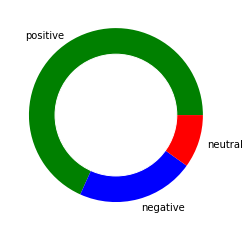

In [10]:
# create data for Pie Chart
pc = count_values_in_column(tw_list, 'sentiment')
names= pc.index
size=pc['Percentage']
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green', 'blue', 'red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## 📈 가격 데이터와 연결짓기

In [11]:
import pyupbit
from matplotlib import rcParams

print(pyupbit.get_tickers())

['KRW-BTC', 'KRW-ETH', 'BTC-ETH', 'BTC-LTC', 'BTC-XRP', 'BTC-ETC', 'BTC-OMG', 'BTC-CVC', 'BTC-DGB', 'BTC-SC', 'BTC-SNT', 'BTC-WAVES', 'BTC-NMR', 'BTC-XEM', 'BTC-QTUM', 'BTC-BAT', 'BTC-LSK', 'BTC-STEEM', 'BTC-DOGE', 'BTC-BNT', 'BTC-XLM', 'BTC-ARDR', 'BTC-ARK', 'BTC-STORJ', 'BTC-GRS', 'BTC-REP', 'BTC-RLC', 'USDT-BTC', 'USDT-ETH', 'USDT-LTC', 'USDT-XRP', 'USDT-ETC', 'KRW-NEO', 'KRW-MTL', 'KRW-LTC', 'KRW-XRP', 'KRW-ETC', 'KRW-OMG', 'KRW-SNT', 'KRW-WAVES', 'KRW-XEM', 'KRW-QTUM', 'KRW-LSK', 'KRW-STEEM', 'KRW-XLM', 'KRW-ARDR', 'KRW-ARK', 'KRW-STORJ', 'KRW-GRS', 'KRW-REP', 'KRW-ADA', 'BTC-ADA', 'BTC-MANA', 'USDT-OMG', 'KRW-SBD', 'BTC-SBD', 'KRW-POWR', 'BTC-POWR', 'KRW-BTG', 'USDT-ADA', 'BTC-DNT', 'BTC-ZRX', 'BTC-TRX', 'BTC-TUSD', 'BTC-LRC', 'KRW-ICX', 'KRW-EOS', 'USDT-TUSD', 'KRW-TRX', 'BTC-POLY', 'USDT-SC', 'USDT-TRX', 'KRW-SC', 'KRW-ONT', 'KRW-ZIL', 'KRW-POLY', 'KRW-ZRX', 'KRW-LOOM', 'BTC-BCH', 'USDT-BCH', 'KRW-BCH', 'BTC-MFT', 'BTC-LOOM', 'KRW-BAT', 'KRW-IOST', 'BTC-RFR', 'KRW-RFR', 'USDT-D

In [12]:
df = pyupbit.get_ohlcv("KRW-ETH", count=700)
df = pd.DataFrame(df)
df = df.drop(['value'], axis=1)

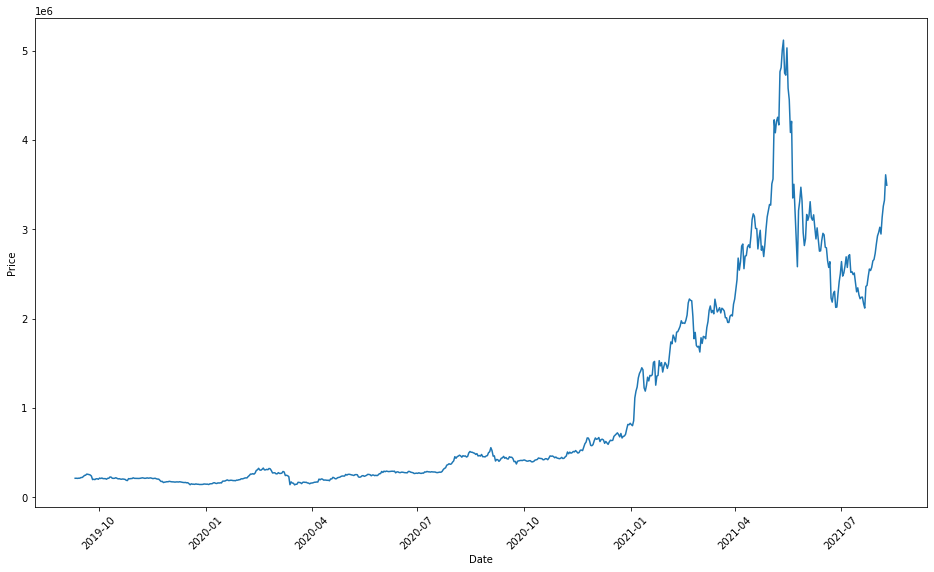

In [13]:
rcParams['figure.figsize'] = 16,9

plt.xlabel('Date')
plt.ylabel('Price')

plt.xticks(rotation="45")
ax = sns.lineplot(data=df['open'])

plt.show()

In [14]:
tw_list

,Timestamp,Comments,text_processed,sentiment,neg,neu,pos,compound
0,2020-06-18 09:00:00,Things I'm excited about (incomplete list) * ...,things i m excited about incomplete list ...,positive,0.098,0.744,0.158,0.2500
1,2021-08-06 09:00:00,How full blocks are in a range of EIP 1559 blo...,how full blocks are in a range of eip 9 blo...,positive,0.152,0.677,0.170,0.4215
2,2021-06-07 09:00:00,Altair: Beacon chain upgrade @dannyryan & ...,altair beacon chain upgrade shared...,negative,0.092,0.872,0.037,-0.5574
3,2021-06-03 09:00:00,"Here's my conversation with @VitalikButerin ,...",here s my conversation with his second ti...,neutral,0.000,1.000,0.000,0.0000
4,2021-05-25 09:00:00,Blockchain voting is overrated among uninforme...,blockchain voting is overrated among uninforme...,neutral,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...
531,2020-06-02 09:00:00,"Yes, the money printer did go brrrrr. But that...",yes the money printer did go brrrrr but that...,positive,0.000,0.836,0.164,0.8622
532,2020-06-02 09:00:00,2020 is first and foremost *not* a financial c...,is first and foremost not a financial c...,positive,0.050,0.652,0.298,0.9228
533,2020-06-02 09:00:00,And bitcoin itself is primarily a financial to...,and bitcoin itself is primarily a financial to...,positive,0.000,0.906,0.094,0.5927
534,2020-06-02 09:00:00,Bitcoin was born out of a crisis that was fund...,bitcoin was born out of a crisis that was fund...,negative,0.157,0.843,0.000,-0.7717


In [15]:
tw_list = tw_list[tw_list['sentiment'] != 'neutral']
tw_group = tw_list.groupby('Timestamp').mean()
tw_group

,neg,neu,pos,compound
Timestamp,,,,
2017-06-28 09:00:00,0.091000,0.909000,0.000000,-0.318200
2020-06-02 09:00:00,0.032917,0.854583,0.112417,0.376617
2020-06-04 09:00:00,0.000000,0.801000,0.199000,0.690800
2020-06-05 09:00:00,0.076000,0.863000,0.061000,-0.102700
2020-06-06 09:00:00,0.066600,0.818200,0.115200,0.262420
...,...,...,...,...
2021-04-23 09:00:00,0.000000,0.929000,0.071000,0.296000
2021-05-23 09:00:00,0.115000,0.794000,0.091000,-0.153100
2021-05-24 09:00:00,0.069000,0.931000,0.000000,-0.353500


In [16]:
def sentiment_analysis(tw_group):
    zxcv = max(tw_group['pos'], tw_group['neg'])
    if tw_group['pos'] == zxcv:
        return 'pos'
#     elif tw_group['neu'] == zxcv:
#         return 'neu'
    elif tw_group['neg'] == zxcv:
        return 'neg'
    
    
tw_group['sentiment'] = tw_group.apply(sentiment_analysis, axis=1)
tw_group

,neg,neu,pos,compound,sentiment
Timestamp,,,,,
2017-06-28 09:00:00,0.091000,0.909000,0.000000,-0.318200,neg
2020-06-02 09:00:00,0.032917,0.854583,0.112417,0.376617,pos
2020-06-04 09:00:00,0.000000,0.801000,0.199000,0.690800,pos
2020-06-05 09:00:00,0.076000,0.863000,0.061000,-0.102700,neg
2020-06-06 09:00:00,0.066600,0.818200,0.115200,0.262420,pos
...,...,...,...,...,...
2021-04-23 09:00:00,0.000000,0.929000,0.071000,0.296000,pos
2021-05-23 09:00:00,0.115000,0.794000,0.091000,-0.153100,neg
2021-05-24 09:00:00,0.069000,0.931000,0.000000,-0.353500,neg


In [17]:
tw_group[tw_group['sentiment'] != 'neu']

,neg,neu,pos,compound,sentiment
Timestamp,,,,,
2017-06-28 09:00:00,0.091000,0.909000,0.000000,-0.318200,neg
2020-06-02 09:00:00,0.032917,0.854583,0.112417,0.376617,pos
2020-06-04 09:00:00,0.000000,0.801000,0.199000,0.690800,pos
2020-06-05 09:00:00,0.076000,0.863000,0.061000,-0.102700,neg
2020-06-06 09:00:00,0.066600,0.818200,0.115200,0.262420,pos
...,...,...,...,...,...
2021-04-23 09:00:00,0.000000,0.929000,0.071000,0.296000,pos
2021-05-23 09:00:00,0.115000,0.794000,0.091000,-0.153100,neg
2021-05-24 09:00:00,0.069000,0.931000,0.000000,-0.353500,neg


In [18]:
result = pd.merge(df.reset_index().rename({'index' : 'Timestamp'}, axis=1), tw_group.reset_index(), how='right', on='Timestamp')[['Timestamp', 'open', 'sentiment']]
result

,Timestamp,open,sentiment
0,2017-06-28 09:00:00,NaN,neg
1,2020-06-02 09:00:00,294200.0,pos
2,2020-06-04 09:00:00,295100.0,pos
3,2020-06-05 09:00:00,292750.0,neg
4,2020-06-06 09:00:00,289200.0,pos
...,...,...,...
151,2021-04-23 09:00:00,2767000.0,pos
152,2021-05-23 09:00:00,2913000.0,neg
153,2021-05-24 09:00:00,2582000.0,neg
154,2021-06-07 09:00:00,3163000.0,neg


In [19]:
result = result.dropna()
result

,Timestamp,open,sentiment
1,2020-06-02 09:00:00,294200.0,pos
2,2020-06-04 09:00:00,295100.0,pos
3,2020-06-05 09:00:00,292750.0,neg
4,2020-06-06 09:00:00,289200.0,pos
5,2020-06-07 09:00:00,290850.0,pos
...,...,...,...
151,2021-04-23 09:00:00,2767000.0,pos
152,2021-05-23 09:00:00,2913000.0,neg
153,2021-05-24 09:00:00,2582000.0,neg
154,2021-06-07 09:00:00,3163000.0,neg


In [20]:
result = result.set_index('Timestamp')
result

,open,sentiment
Timestamp,,
2020-06-02 09:00:00,294200.0,pos
2020-06-04 09:00:00,295100.0,pos
2020-06-05 09:00:00,292750.0,neg
2020-06-06 09:00:00,289200.0,pos
2020-06-07 09:00:00,290850.0,pos
...,...,...
2021-04-23 09:00:00,2767000.0,pos
2021-05-23 09:00:00,2913000.0,neg
2021-05-24 09:00:00,2582000.0,neg


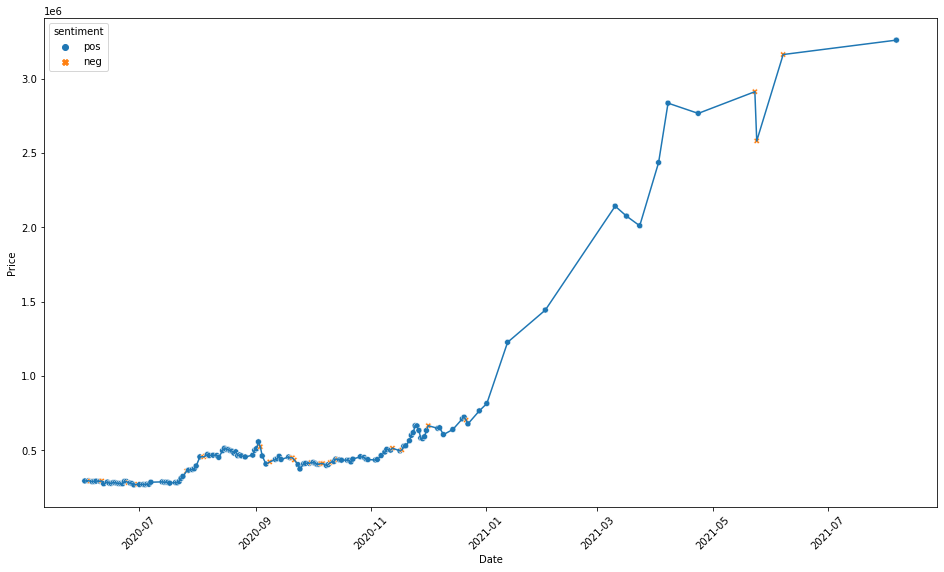

In [22]:
rcParams['figure.figsize'] = 16,9

plt.xlabel('Date')
plt.ylabel('Price')

plt.xticks(rotation="45")
# ax = sns.lineplot(data=df['open'])
ax = sns.lineplot(data=result['open'])
ax = sns.scatterplot(data=result, x='Timestamp', y='open', hue='sentiment', style='sentiment')
plt.show()

In [39]:
import plotly.graph_objects as go

fig = go.Figure()
# fig.add_trace(go.Scatter(x=result.index, y=result['open']))
fig.add_trace(go.Scatter(x=result.index, y=result['open'], mode='lines+markers', name='pos'))
fig.add_trace(go.Scatter(x=result[result['sentiment'] == 'neg'].index, y=result[result['sentiment'] == 'neg']['open'], mode='markers', name='neg'))
fig.show()